# Best-of-n sampling

In order to align language models with human intent, we train reward models to predict the human preference and use the reward model’s predictions as a proxy objective.
Best-of-n sampling means that we use a language model to sample `n` times and take the sample that scores the highest according to the proxy objective.

In [208]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 10

In [209]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output: list[int]):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

<class 'numpy.ndarray'>


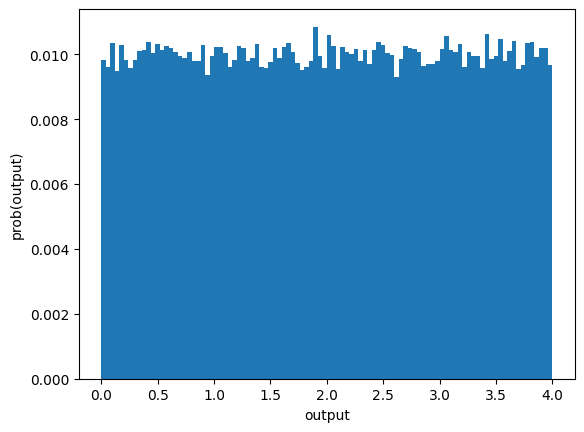

In [210]:
def plot_model_output() -> None:
    outputs: np.ndarray = model(NUM_SAMPLES)
    print(type(outputs))
    probs, bins = histogram(outputs)
    plt.hist(bins[:-1], bins, weights=probs)
    plt.xlabel("output")
    plt.ylabel("prob(output)")

# Plot of the output of the language model
plot_model_output()

In [212]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    mid: float = (MAX - MIN)/2
    return (5 - (abs(mid - output)))

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    reward = reward_model_ground_truth(output)
    noise: float = random.uniform(-0.1, 0.1)
    return reward + noise

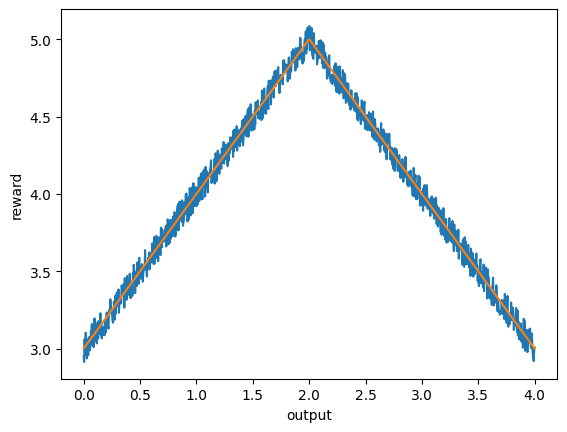

In [213]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.plot(outputs, rewards_proxy, alpha=1.0)
    plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()

In [216]:
def best_of_n(n: int, reward_model):
    best_reward: float = float('-inf')
    best_output = None
    outputs = model(n)
    for output in outputs:
        reward = reward_model(output)
        if reward > best_reward:
            best_reward = reward
            best_output = output
    return best_output, best_reward

def optimized_prob_distribution(n):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        best_output, _  = best_of_n(n, reward_model_proxy)
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# Probabilities before best-of-n sampling
probs_initial: list[int] = BINS * [1/BINS]

# Probabilities after best-of-n sampling
probs_optimized, bins = optimized_prob_distribution(n=N)

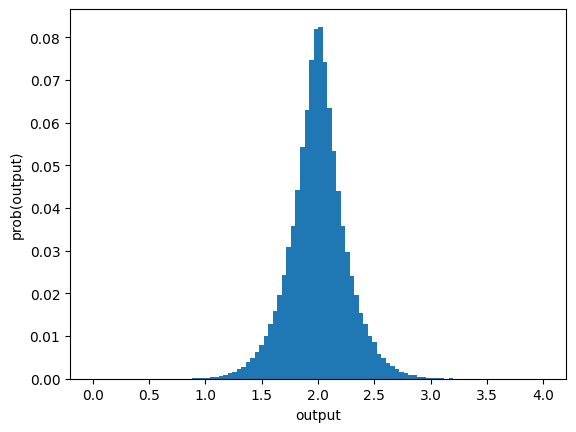

In [217]:
def plot_optimized_output() -> None:
    plt.hist(bins[:-1], bins, weights=probs_optimized)
    plt.xlabel("output")
    plt.ylabel("prob(output)")

# Plot the output after best-of-n sampling using the proxy reward model
plot_optimized_output()

In [222]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    return np.log(n) - (n-1)/n

def kl_divergence_numerical(p, q):
    return np.sum(np.where(p > 0.0, p * np.log(p / q), 0.0))

In [224]:
# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [2, 4, 8, 16, 32, 64, 128, 256]:
    kl_div = kl_divergence_analytical(n)
    print(f"n={n}, kl_divergence={kl_div}")

n=2, kl_divergence=0.1931471805599453
n=4, kl_divergence=0.6362943611198906
n=8, kl_divergence=1.2044415416798357
n=16, kl_divergence=1.8350887222397811
n=32, kl_divergence=2.4969859027997265
n=64, kl_divergence=3.1745080833596715
n=128, kl_divergence=3.859842763919617
n=256, kl_divergence=4.549083694479562


In [220]:
# Validate that analytical KL and empirical KL are the same
kl_div = kl_divergence_analytical(n=N)
print("kl divergence (analytical): ", kl_div)
kl_div = kl_divergence_numerical(probs_optimized, probs_initial)
print("kl_divergence (numerical): ", kl_div)

kl divergence (analytical):  1.402585092994046
kl_divergence (numerical):  1.3671669901006966


/var/folders/53/6sljrh9n5vv5b74vh630s6bc0000gq/T/ipykernel_41501/93308751.py:7: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p > 0.0, p * np.log(p / q), 0.0))
/var/folders/53/6sljrh9n5vv5b74vh630s6bc0000gq/T/ipykernel_41501/93308751.py:7: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p > 0.0, p * np.log(p / q), 0.0))


n 2 – ground truth 4.33 – proxy 4.29
n 4 – ground truth 4.62 – proxy 4.60
n 8 – ground truth 4.76 – proxy 4.76
n 16 – ground truth 4.89 – proxy 4.88
n 32 – ground truth 4.94 – proxy 4.96
n 64 – ground truth 4.97 – proxy 5.00
n 128 – ground truth 4.99 – proxy 5.03
n 256 – ground truth 4.99 – proxy 5.05
n 512 – ground truth 5.00 – proxy 5.07
n 1024 – ground truth 5.00 – proxy 5.08
n 2048 – ground truth 5.00 – proxy 5.08


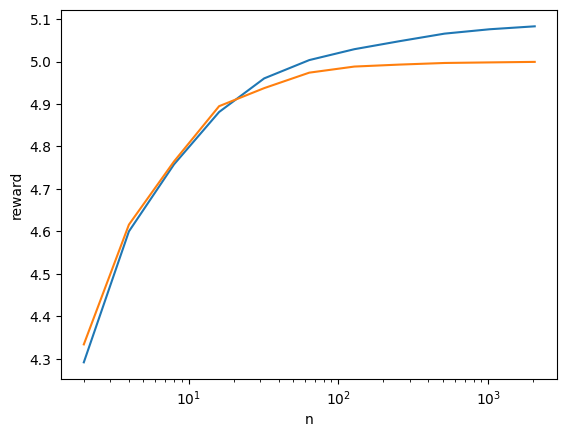

In [221]:
def estimate_reward(n:int, reward_model: Callable) -> float:
    rewards: list[float] = []
    for _ in range(100):
        _, best_reward = best_of_n(n, reward_model)
        rewards.append(best_reward)
    return np.mean(rewards)

rewards_ground_truth: list[float] = []
rewards_proxy: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_ground_truth: float = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)
    reward_proxy = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    print(f"n {n} – ground truth {reward_ground_truth:.2f} – proxy {reward_proxy:.2f}")

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_proxy)
plt.plot(RANGE_N, rewards_ground_truth)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['proxy', 'ground truth'])
plt.show()